# **Section B**

In [ ]:
import numpy as np

class NeuralNetwork:
    def __init__(self, nLayers, neuronsPerLayer, lr, activationFunc, weightInitFunc, epochs, batchSize):
        self.nLayers = nLayers
        self.neuronsPerLayer = neuronsPerLayer
        self.lr = lr
        self.activationFunc, self.activationDerivative = activationFunc
        self.weightInitFunc = weightInitFunc
        self.epochs = epochs
        self.batchSize = batchSize
        self.weights = [self.weightInitFunc(neuronsIn, neuronsOut)
                        for neuronsIn, neuronsOut in zip(neuronsPerLayer[:-1], neuronsPerLayer[1:])]
        self.biases = [np.zeros((1, neuronsOut)) for neuronsOut in neuronsPerLayer[1:]]

    def _forward(self, x):
        activations = [x]
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            x = self.activationFunc(x @ w + b)
            activations.append(x)
        output = x @ self.weights[-1] + self.biases[-1]
        activations.append(output)
        return activations

    def _backward(self, x, y, activations):
        gradientsW, gradientsB = [], []
        error = activations[-1] - y
        for i in reversed(range(len(self.weights))):
            gradientsW.insert(0, activations[i].T @ error / x.shape[0])
            gradientsB.insert(0, np.mean(error, axis=0, keepdims=True))
            if i != 0:
                error = (error @ self.weights[i].T) * self.activationDerivative(activations[i])
        return gradientsW, gradientsB

    def _updateWeights(self, gradientsW, gradientsB):
        self.weights = [w - self.lr * dw for w, dw in zip(self.weights, gradientsW)]
        self.biases = [b - self.lr * db for b, db in zip(self.biases, gradientsB)]

    def fit(self, x, y):
        for epoch in range(self.epochs):
            for i in range(0, x.shape[0], self.batchSize):
                batchX, batchY = x[i:i + self.batchSize], y[i:i + self.batchSize]
                activations = self._forward(batchX)
                gradientsW, gradientsB = self._backward(batchX, batchY, activations)
                self._updateWeights(gradientsW, gradientsB)

    def predict(self, x):
        output = self._forward(x)[-1]
        return np.argmax(output, axis=1)

    def predictProba(self, x):
        output = self._forward(x)[-1]
        return self._softmax(output)

    def score(self, x, y):
        predictions = self.predict(x)
        return np.mean(predictions == np.argmax(y, axis=1))

    @staticmethod
    def _softmax(x):
        expVals = np.exp(x - np.max(x, axis=1, keepdims=True))
        return expVals / np.sum(expVals, axis=1, keepdims=True)


In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoidDerivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def tanh(x):
    return np.tanh(x)

def tanhDerivative(x):
    return 1 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def reluDerivative(x):
    return np.where(x > 0, 1, 0)

def leakyRelu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leakyReluDerivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    expVals = np.exp(x - np.max(x, axis=1, keepdims=True))
    return expVals / np.sum(expVals, axis=1, keepdims=True)


In [ ]:
import numpy as np

def zeroInit(neuronsIn, neuronsOut):
    return np.zeros((neuronsIn, neuronsOut))

def randomInit(neuronsIn, neuronsOut):
    limit = np.sqrt(6 / (neuronsIn + neuronsOut))
    return np.random.uniform(-limit, limit, (neuronsIn, neuronsOut))

def normalInit(neuronsIn, neuronsOut):
    stddev = np.sqrt(2 / (neuronsIn + neuronsOut))
    return np.random.normal(0, stddev, (neuronsIn, neuronsOut))


In [ ]:
import numpy as np
import struct
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def loadMnistImages(filePath):
    with open(filePath, 'rb') as f:
        _, _, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.fromfile(f, dtype=np.uint8).reshape(-1, rows * cols)
    return data / 255.0

def loadMnistLabels(filePath):
    with open(filePath, 'rb') as f:
        f.read(8)
        labels = np.fromfile(f, dtype=np.uint8)
    return np.eye(10)[labels]

trainImages = loadMnistImages('archive/train-images.idx3-ubyte')
trainLabels = loadMnistLabels('archive/train-labels.idx1-ubyte')
testImages = loadMnistImages('archive/t10k-images.idx3-ubyte')
testLabels = loadMnistLabels('archive/t10k-labels.idx1-ubyte')

xTrain, xVal, yTrain, yVal = train_test_split(trainImages, trainLabels, test_size=0.2, random_state=42)
xVal, xTest, yVal, yTest = train_test_split(xVal, yVal, test_size=0.5, random_state=42)


In [ ]:
layerSizes = [784, 256, 128, 64, 32, 10]
learningRate = 2e-3
numEpochs = 20
batchSize = 256


In [ ]:
import pickle
import numpy as np

def trainAndValidateNN(nn, xTrain, yTrain, xVal, yVal, numEpochs, patience):
    trainLosses, valLosses, trainAccuracies, valAccuracies = [], [], [], []
    bestValLoss = float('inf')
    epochsWithoutImprovement = 0

    for epoch in range(numEpochs):
        nn.fit(xTrain, yTrain)

        trainLoss, valLoss = calculateLoss(nn, xTrain, yTrain, xVal, yVal)
        trainAccuracy, valAccuracy = calculateAccuracy(nn, xTrain, yTrain, xVal, yVal)

        trainLosses.append(trainLoss)
        valLosses.append(valLoss)
        trainAccuracies.append(trainAccuracy)
        valAccuracies.append(valAccuracy)

        if valLoss < bestValLoss:
            bestValLoss = valLoss
            epochsWithoutImprovement = 0
        else:
            epochsWithoutImprovement += 1

        if epochsWithoutImprovement >= patience:
            print(f"Early stopping at epoch {epoch + 1} for lack of improvement.")
            break

        print(f"Epoch: {epoch + 1}, Train Loss: {trainLoss:.4f}, Val Loss: {valLoss:.4f}, "
              f"Train Acc: {trainAccuracy:.4f}, Val Acc: {valAccuracy:.4f}")

    return trainLosses, valLosses, trainAccuracies, valAccuracies

def calculateLoss(nn, xTrain, yTrain, xVal, yVal):
    trainOutput = nn._forward(xTrain)[-1]
    valOutput = nn._forward(xVal)[-1]

    trainLoss = np.mean(np.square(yTrain - trainOutput))
    valLoss = np.mean(np.square(yVal - valOutput))

    return trainLoss, valLoss

def calculateAccuracy(nn, xTrain, yTrain, xVal, yVal):
    trainOutput = nn._forward(xTrain)[-1]
    valOutput = nn._forward(xVal)[-1]

    trainAccuracy = np.mean(np.argmax(trainOutput, axis=1) == np.argmax(yTrain, axis=1))
    valAccuracy = np.mean(np.argmax(valOutput, axis=1) == np.argmax(yVal, axis=1))

    return trainAccuracy, valAccuracy

def trainModels(activationFunctions, weightInitializations, layerSizes, xTrain, yTrain, xVal, yVal, numEpochs, batchSize, learningRate, patience):
    results = {}

    for actName, actFuncs in activationFunctions.items():
        for initName, initFunc in weightInitializations.items():
            nn = NeuralNetwork(nLayers=len(layerSizes), neuronsPerLayer=layerSizes, lr=learningRate,
                               activationFunc=actFuncs, weightInitFunc=initFunc, epochs=numEpochs,
                               batchSize=batchSize)

            print(f"Training model with {actName} activation and {initName} weight initialization.")


            trainLosses, valLosses, trainAccuracies, valAccuracies = trainAndValidateNN(
                nn, xTrain, yTrain, xVal, yVal, numEpochs, patience)


            results[(actName, initName)] = {
                'trainLosses': trainLosses,
                'valLosses': valLosses,
                'trainAccuracies': trainAccuracies,
                'valAccuracies': valAccuracies
            }


            with open(f'{actName}_{initName}_model.pkl', 'wb') as f:
                pickle.dump(nn, f)

    return results


activationFunctions = {
    'sigmoid': (sigmoid, sigmoidDerivative),
    'tanh': (tanh, tanhDerivative),
    'relu': (relu, reluDerivative),
    'leakyRelu': (leakyRelu, leakyReluDerivative)
}

weightInitializations = {
    'zeroInit': zeroInit,
    'randomInit': randomInit,
    'normalInit': normalInit
}

results = {}
patience = 3
bestValLoss = float('inf')
epochsWithoutImprovement = 0

results = trainModels(activationFunctions, weightInitializations, layerSizes, xTrain, yTrain, xVal, yVal, numEpochs, batchSize, learningRate, patience)


Training model with sigmoid activation and zeroInit weight initialization.
Epoch: 1, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 2, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 3, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 4, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 5, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 6, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 7, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 8, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 9, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 10, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 11, Train Loss: 0.0900, Val Loss: 0.0900, Train Acc: 0.1129, Val Acc: 0.1137
Epoch: 12,

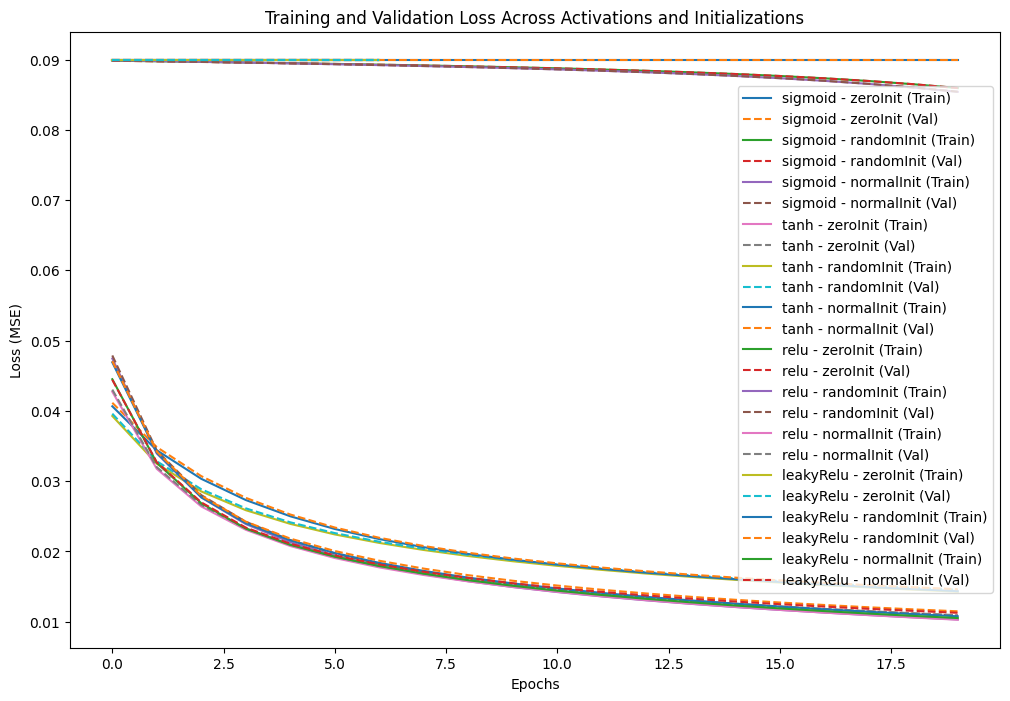

In [ ]:
plt.figure(figsize=(12, 8))
for (actName, initName), metrics in results.items():
    trainLosses = metrics['trainLosses']
    valLosses = metrics['valLosses']
    plt.plot(trainLosses, label=f'{actName} - {initName} (Train)')
    plt.plot(valLosses, linestyle='--', label=f'{actName} - {initName} (Val)')

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Across Activations and Initializations")
plt.legend()
plt.show()


In [ ]:
import pickle

def evaluateActivationInitializationCombinations(xTest: np.ndarray, yTest: np.ndarray) -> None:
    activations = ['leakyRelu', 'relu', 'sigmoid', 'tanh']
    initializations = ['zeroInit', 'randomInit', 'normalInit']

    for activation in activations:
        for init in initializations:
            filename = f"{activation}_{init}_model.pkl"
            try:
                with open(filename, 'rb') as file:
                    loadedModel = pickle.load(file)
                    accuracy = loadedModel.score(xTest, yTest)
                    print(f"Test Accuracy for {filename}: {accuracy:.4f}")
            except FileNotFoundError:
                print(f"{filename} not found.")


evaluateActivationInitializationCombinations(xTest, yTest)

Test Accuracy for leakyRelu_zeroInit_model.pkl: 0.1067
Test Accuracy for leakyRelu_randomInit_model.pkl: 0.9525
Test Accuracy for leakyRelu_normalInit_model.pkl: 0.9545
Test Accuracy for relu_zeroInit_model.pkl: 0.1067
Test Accuracy for relu_randomInit_model.pkl: 0.9518
Test Accuracy for relu_normalInit_model.pkl: 0.9530
Test Accuracy for sigmoid_zeroInit_model.pkl: 0.1067
Test Accuracy for sigmoid_randomInit_model.pkl: 0.4010
Test Accuracy for sigmoid_normalInit_model.pkl: 0.4147
Test Accuracy for tanh_zeroInit_model.pkl: 0.1067
Test Accuracy for tanh_randomInit_model.pkl: 0.9442
Test Accuracy for tanh_normalInit_model.pkl: 0.9430


# **Section C**

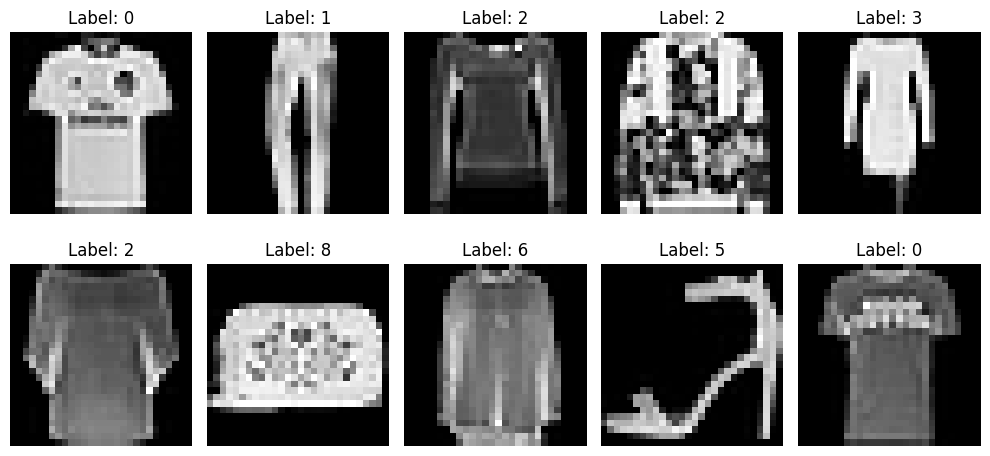

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def loadData(filePath: str, numRows: int) -> pd.DataFrame:
    return pd.read_csv(filePath).head(numRows)

def preprocessData(data: pd.DataFrame) -> tuple:
    X = data.iloc[:, 1:].values / 255.0
    y = data.iloc[:, 0].values
    return X, y

def plotImages(XTest: np.ndarray, yTest: np.ndarray, numImages: int = 10) -> None:
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(XTest[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Label: {yTest[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


trainData = loadData('fashion-mnist_train.csv', 8000)
testData = loadData('fashion-mnist_test.csv', 2000)

XTrain, yTrain = preprocessData(trainData)
XTest, yTest = preprocessData(testData)

plotImages(XTest, yTest)


Test Accuracy for activation 'logistic': 0.4725
Test Accuracy for activation 'tanh': 0.8462
Test Accuracy for activation 'relu': 0.8462
Test Accuracy for activation 'identity': 0.8475


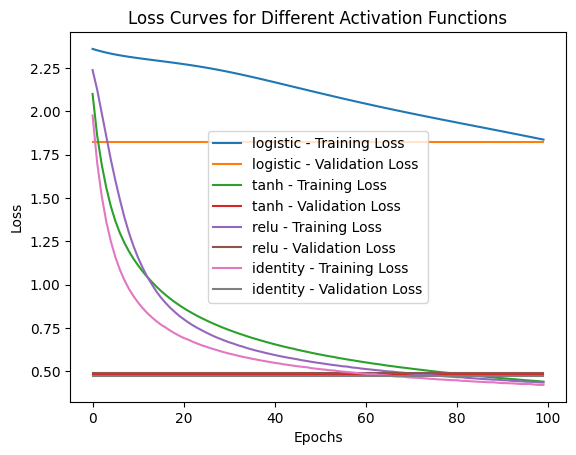

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

def splitData(X: np.ndarray, y: np.ndarray, testSize: float = 0.2) -> tuple:
    return train_test_split(X, y, test_size=testSize)

def trainMLPClassifier(XTrain: np.ndarray, yTrain: np.ndarray, layerSizes: list, activation: str,
                       batchSize: int, learningRate: float, epochs: int, classes: np.ndarray) -> tuple:
    mlp = MLPClassifier(hidden_layer_sizes=layerSizes, activation=activation, solver='adam',
                        batch_size=batchSize, learning_rate_init=learningRate, max_iter=1, warm_start=True)

    trainLoss, valLoss = [], []
    for epoch in range(epochs):
        mlp.partial_fit(XTrain, yTrain, classes=classes)
        trainLoss.append(log_loss(yTrain, mlp.predict_proba(XTrain)))

    return mlp, trainLoss

def computeLossCurve(mlp: MLPClassifier, XVal: np.ndarray, yVal: np.ndarray, epochs: int) -> list:
    return [log_loss(yVal, mlp.predict_proba(XVal)) for _ in range(epochs)]

def plotLossCurves(trainLosses: list, valLosses: list, activations: list) -> None:
    for activation, trainLoss, valLoss in zip(activations, trainLosses, valLosses):
        plt.plot(trainLoss, label=f'{activation} - Training Loss')
        plt.plot(valLoss, label=f'{activation} - Validation Loss')

    plt.title('Loss Curves for Different Activation Functions')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


XTrainSplit, XTempSplit, yTrainSplit, yTempSplit = splitData(XTrain, yTrain, testSize=0.2)
XValSplit, XTestSplit, yValSplit, yTestSplit = splitData(XTempSplit, yTempSplit, testSize=0.5)

layerSizes = [128, 64, 32]
activations = ['logistic', 'tanh', 'relu', 'identity']
batchSize = 128
learningRate = 2e-5
epochs = 100
classes = np.unique(yTrain)

trainLosses = []
valLosses = []
testAccuracies = []

for activation in activations:
    mlp, trainLoss = trainMLPClassifier(XTrainSplit, yTrainSplit, layerSizes, activation, batchSize, learningRate, epochs, classes)

    valLoss = computeLossCurve(mlp, XValSplit, yValSplit, epochs)
    testAccuracy = mlp.score(XTestSplit, yTestSplit)

    trainLosses.append(trainLoss)
    valLosses.append(valLoss)
    testAccuracies.append(testAccuracy)

    print(f"Test Accuracy for activation '{activation}': {testAccuracy:.4f}")

plotLossCurves(trainLosses, valLosses, activations)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

def createMLPClassifier(layerSizes: list, activation: str, epochs: int) -> MLPClassifier:
    return MLPClassifier(hidden_layer_sizes=layerSizes, activation=activation, max_iter=epochs)

def performGridSearch(mlp: MLPClassifier, paramGrid: dict, XTrain: np.ndarray, yTrain: np.ndarray) -> GridSearchCV:
    gridSearch = GridSearchCV(mlp, paramGrid, cv=3, verbose=2)
    gridSearch.fit(XTrain, yTrain)
    return gridSearch


paramGrid = {
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [1e-5, 2e-5, 5e-5],
    'batch_size': [64, 128]
}

mlp = createMLPClassifier(layerSizes, 'relu', epochs)
gridSearch = performGridSearch(mlp, paramGrid, XTrain, yTrain)

print("Best parameters found:", gridSearch.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=adam; total time=  42.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=adam; total time=  42.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=adam; total time=  42.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=sgd; total time=  34.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=sgd; total time=  37.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=sgd; total time=  33.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=2e-05, solver=adam; total time=  42.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=2e-05, solver=adam; total time=  42.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=2e-05, solver=adam; total time=  43.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=2e-05, solver=sgd; total time=  43.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=2e-05, solver=sgd; total time=  37.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=2e-05, solver=sgd; total time=  36.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=5e-05, solver=adam; total time=  40.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=5e-05, solver=adam; total time=  42.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=5e-05, solver=adam; total time=  44.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=5e-05, solver=sgd; total time=  36.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=5e-05, solver=sgd; total time=  36.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=5e-05, solver=sgd; total time=  37.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=adam; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=adam; total time=  29.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=adam; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=sgd; total time=  25.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=sgd; total time=  24.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=sgd; total time=  25.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=2e-05, solver=adam; total time=  28.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=2e-05, solver=adam; total time=  30.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=2e-05, solver=adam; total time=  28.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=2e-05, solver=sgd; total time=  26.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=2e-05, solver=sgd; total time=  23.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=2e-05, solver=sgd; total time=  26.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=5e-05, solver=adam; total time=  28.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=5e-05, solver=adam; total time=  28.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=5e-05, solver=adam; total time=  28.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=5e-05, solver=sgd; total time=  25.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=5e-05, solver=sgd; total time=  24.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[CV] END batch_size=128, learning_rate_init=5e-05, solver=sgd; total time=  25.5s
Best parameters found: {'batch_size': 64, 'learning_rate_init': 5e-05, 'solver': 'adam'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.10252904
Iteration 2, loss = 0.09974676
Iteration 3, loss = 0.09482753
Iteration 4, loss = 0.08615064
Iteration 5, loss = 0.07544233
Iteration 6, loss = 0.06477921
Iteration 7, loss = 0.05563675
Iteration 8, loss = 0.04851851
Iteration 9, loss = 0.04331075
Iteration 10, loss = 0.03963526
Iteration 11, loss = 0.03704801
Iteration 12, loss = 0.03520564
Iteration 13, loss = 0.03382422
Iteration 14, loss = 0.03274436
Iteration 15, loss = 0.03185261
Iteration 16, loss = 0.03103771
Iteration 17, loss = 0.03024236
Iteration 18, loss = 0.02949164
Iteration 19, loss = 0.02879863
Iteration 20, loss = 0.02816548
Iteration 21, loss = 0.02758453
Iteration 22, loss = 0.02703929
Iteration 23, loss = 0.02653906
Iteration 24, loss = 0.02608421
Iteration 25, loss = 0.02567688
Iteration 26, loss = 0.02530785
Iteration 27, loss = 0.02496165
Iteration 28, loss = 0.02463696
Iteration 29, loss = 0.02432419
Iteration 30, loss = 0.02402104
Iteration 31, loss = 0.02371632
Iteration 32, los

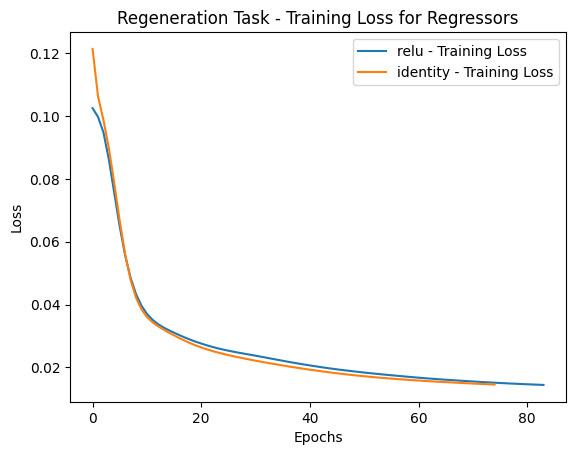

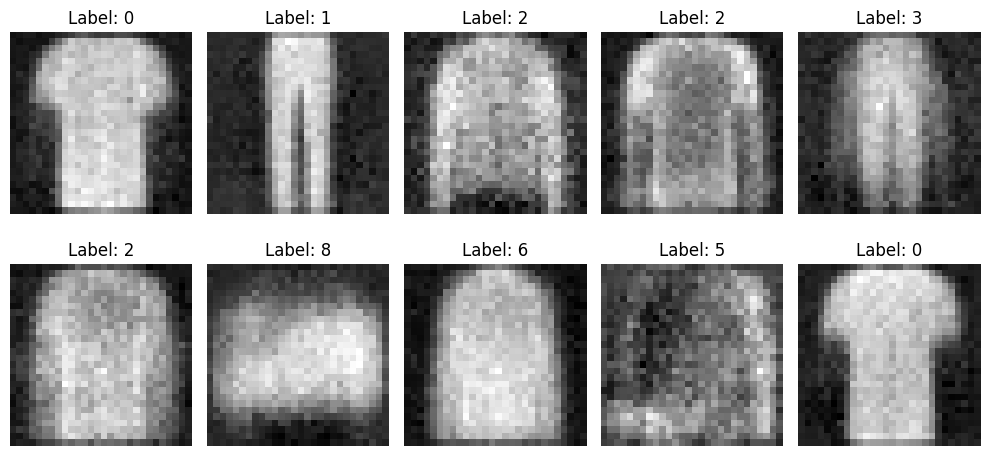

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

def createMLPRegressor(layerSizes: list, activation: str, learningRate: float, epochs: int) -> MLPRegressor:
    return MLPRegressor(hidden_layer_sizes=layerSizes, activation=activation, solver='adam',
                        learning_rate_init=learningRate, max_iter=epochs, verbose=True)

def trainRegressor(regressor: MLPRegressor, XTrain: np.ndarray) -> MLPRegressor:
    regressor.fit(XTrain, XTrain)
    return regressor

def plotTrainingLoss(regressors: dict) -> None:
    for activation, regressor in regressors.items():
        plt.plot(regressor.loss_curve_, label=f'{activation} - Training Loss')

    plt.title('Regeneration Task - Training Loss for Regressors')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plotRegeneratedImages(regressors: dict, XTest: np.ndarray, yTest: np.ndarray) -> None:
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        regenerated = regressors['relu'].predict(XTest[i].reshape(1, -1)).reshape(28, 28)
        ax.imshow(regenerated, cmap='gray')
        ax.set_title(f'Label: {yTest[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


layerSizesReg = [128, 64, 32, 64, 128]
activations = ['relu', 'identity']
regressors = {}

for activation in activations:
    reg = createMLPRegressor(layerSizesReg, activation, learningRate, epochs)
    trainedRegressor = trainRegressor(reg, XTrain)
    regressors[activation] = trainedRegressor

plotTrainingLoss(regressors)
plotRegeneratedImages(regressors, XTest, yTest)



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def trainMLPClassifier(XTrainRegFeatures: np.ndarray, yTrain: np.ndarray, layerSizes: list, activation: str, learningRate: float) -> MLPClassifier:
    mlp = MLPClassifier(hidden_layer_sizes=layerSizes, activation=activation,
                        solver='adam', learning_rate_init=learningRate, max_iter=200)
    mlp.fit(XTrainRegFeatures, yTrain)
    return mlp

def calculateAccuracy(model: MLPClassifier, XTestRegFeatures: np.ndarray, yTest: np.ndarray) -> float:
    yPred = model.predict(XTestRegFeatures)
    return accuracy_score(yTest, yPred)


XTrainRegFeatures = regressors['relu'].predict(XTrain)
XTestRegFeatures = regressors['relu'].predict(XTest)

layerSizesSmall = [32, 32]

mlpSmallRelu = trainMLPClassifier(XTrainRegFeatures, yTrain, layerSizesSmall, 'relu', learningRate)
accuracyRelu = calculateAccuracy(mlpSmallRelu, XTestRegFeatures, yTest)
print("Accuracy with feature vector using 'relu' activation:", accuracyRelu)

mlpSmallIdentity = trainMLPClassifier(XTrainRegFeatures, yTrain, layerSizesSmall, 'identity', learningRate)
accuracyIdentity = calculateAccuracy(mlpSmallIdentity, XTestRegFeatures, yTest)
print("Accuracy with feature vector using 'identity' activation:", accuracyIdentity)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy with feature vector using 'relu' activation: 0.7465
Accuracy with feature vector using 'identity' activation: 0.7395


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
